In [1]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io, color, exposure
from skimage.util import img_as_ubyte
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from pathlib import Path
import re
import h5py
import cv2 as cv
from scipy import signal
import scipy.ndimage
import seaborn as sns
import pandas as pd
import scanpy as sc
import anndata as ad
import cv2

from matplotlib.pyplot import rc_context
sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data'

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# Read images

In [4]:
h5_data_dir = p_dir / 'data' / 'h5'

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f'{experiment}.hdf5', 'r') as f:
        imgs = f[name][:]
        labels = list(f[name].attrs['labels'])
        fov = f[name].attrs['fov']
    return imgs, labels, fov

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (1, 99.9))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98), out_range = (0, 255)).astype(np.uint8)
    return img_rescale
    
def get_imgs_index(imgs, index_list):
    
    imgs_subset = imgs[index_list, :,:]
    img_combined = np.sum(imgs_subset, axis=0)
    return contrast_stretching(img_combined)

def get_mass(file):
    labels = ['total', 'rest']
    with open(file) as infile:
        next(infile)
        for line in infile:
            mass = float(line.split("\t")[1])
            mass = np.round(mass, 1)
            labels.append(mass)
    return labels

In [5]:
masses = [50,190,191,193,194,196,198,200,201,202,203,55,204,205,206,207,208,209,210,212,214,216,56,217,220,221,222,223,224,225,226,229,232,57,236,238,240,243,246,248,249,250,252,253,58,254,256,259,261,263,265,267,269,273,275,59,276,279,282,289,301,307,308,310,318,60,328,332,339,344,353,359,369,380,385,397,61,412,424,431,436,448,457,468,474,479,498,63,501,510,514,518,520,529,544,552,570,586,64,593,610,1,66,67,68,69,70,71,72,73,74,75,16,76,78,79,80,81,82,83,84,85,86,17,87,88,91,93,95,96,97,98,100,102,30,104,105,107,109,111,112,115,116,117,118,34,121,122,124,125,127,128,131,133,134,138,35,140,141,143,144,145,146,148,149,150,151,42,153,155,156,158,159,161,162,164,165,166,44,167,168,169,170,171,173,179,182,184,185]
masses.sort()
SIMS_masses = ['Total', 'Rest'] + masses

In [6]:
experiment = 'Lung'

ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
images_dir = p_dir / 'figures' / 'surface_plot'

datasets = listdir(ts_data_dir)
datasets = [dataset for dataset in datasets if 'auto' not in dataset]

# Check SNR ratio of images

In [22]:
from skimage import metrics

import numpy as np
import scipy.io

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [23]:
datasets

['B5_1',
 'B5_2',
 'B5_3',
 'C6_1',
 'C6_2',
 'C6_3',
 'C6_4',
 'D4_1',
 'D4_2',
 'D4_3',
 'E4_1',
 'E4_2',
 'E4_3',
 'E4_4',
 'E6_1',
 'E6_2',
 'E6_3',
 'F4_1',
 'F4_2',
 'F4_3',
 'F7_1',
 'F7_2',
 'F7_3',
 'F7_4']

In [40]:
imgs, labels, fov= get_imgs(experiment, datasets[-2])

In [65]:
snr = []
for img in imgs[3:]:
    snr.append(signaltonoise(img, axis=None))

In [66]:
snr_sorted = np.argsort(snr)
snr_top_indices = sorted(snr_sorted[-20:])

In [67]:
snr_top_indices

[0, 4, 5, 7, 15, 16, 17, 23, 24, 25, 26, 34, 36, 39, 43, 44, 49, 57, 58, 96]

In [60]:
masses = [
    50,
    190,
    191,
    193,
    194,
    196,
    198,
    200,
    201,
    202,
    203,
    55,
    204,
    205,
    206,
    207,
    208,
    209,
    210,
    212,
    214,
    216,
    56,
    217,
    220,
    221,
    222,
    223,
    224,
    225,
    226,
    229,
    232,
    57,
    236,
    238,
    240,
    243,
    246,
    248,
    249,
    250,
    252,
    253,
    58,
    254,
    256,
    259,
    261,
    263,
    265,
    267,
    269,
    273,
    275,
    59,
    276,
    279,
    282,
    289,
    301,
    307,
    308,
    310,
    318,
    60,
    328,
    332,
    339,
    344,
    353,
    359,
    369,
    380,
    385,
    397,
    61,
    412,
    424,
    431,
    436,
    448,
    457,
    468,
    474,
    479,
    498,
    63,
    501,
    510,
    514,
    518,
    520,
    529,
    544,
    552,
    570,
    586,
    64,
    593,
    610,
    1,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    16,
    76,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    17,
    87,
    88,
    91,
    93,
    95,
    96,
    97,
    98,
    100,
    102,
    30,
    104,
    105,
    107,
    109,
    111,
    112,
    115,
    116,
    117,
    118,
    34,
    121,
    122,
    124,
    125,
    127,
    128,
    131,
    133,
    134,
    138,
    35,
    140,
    141,
    143,
    144,
    145,
    146,
    148,
    149,
    150,
    151,
    42,
    153,
    155,
    156,
    158,
    159,
    161,
    162,
    164,
    165,
    166,
    44,
    167,
    168,
    169,
    170,
    171,
    173,
    179,
    182,
    184,
    185,
]
masses.sort()
masses = ["Total", "Rest"] + masses

2


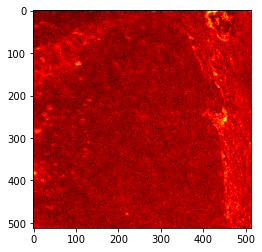

6


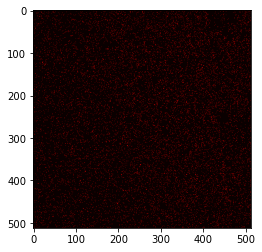

7


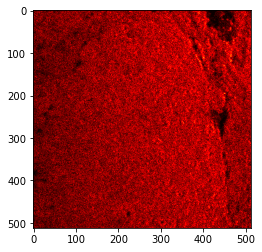

9


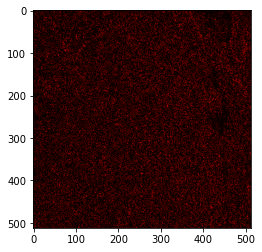

17


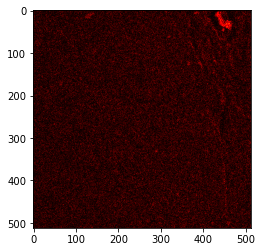

18


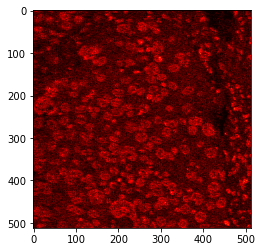

19


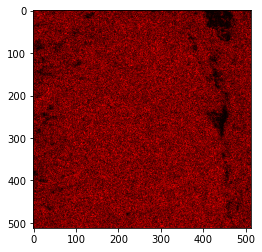

25


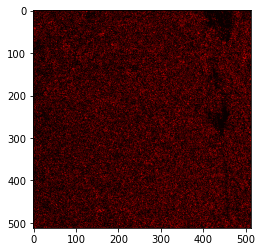

26


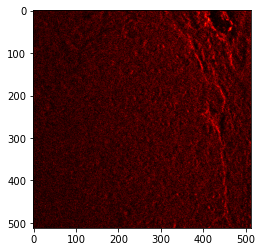

27


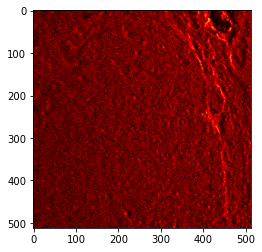

28


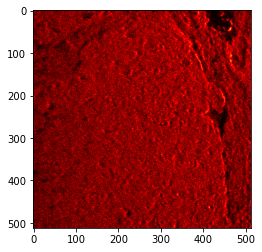

36


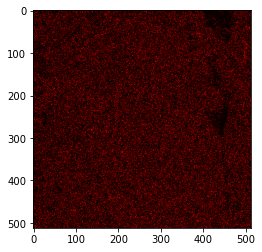

38


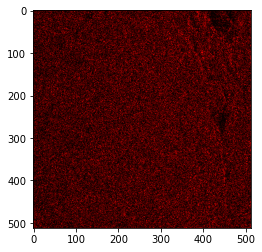

41


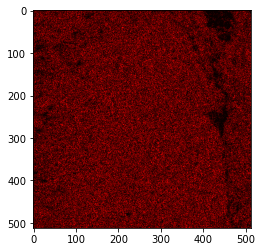

45


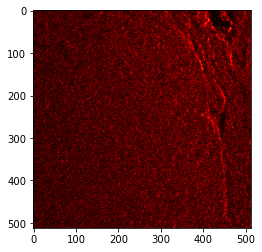

46


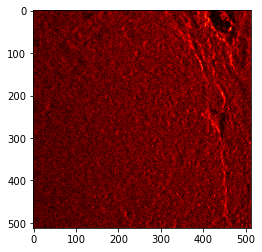

51


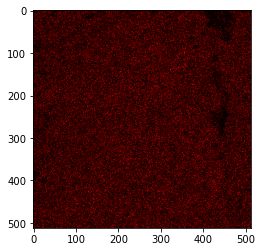

59


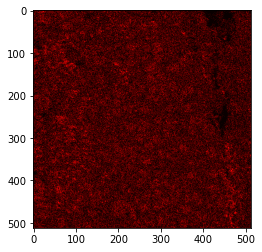

60


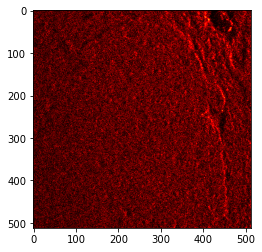

98


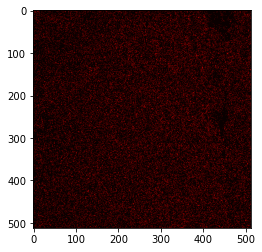

In [61]:
for i in snr_top_indices:
    print(i+2)
    plt.imshow(imgs[i+2], cmap='hot')
    plt.show()

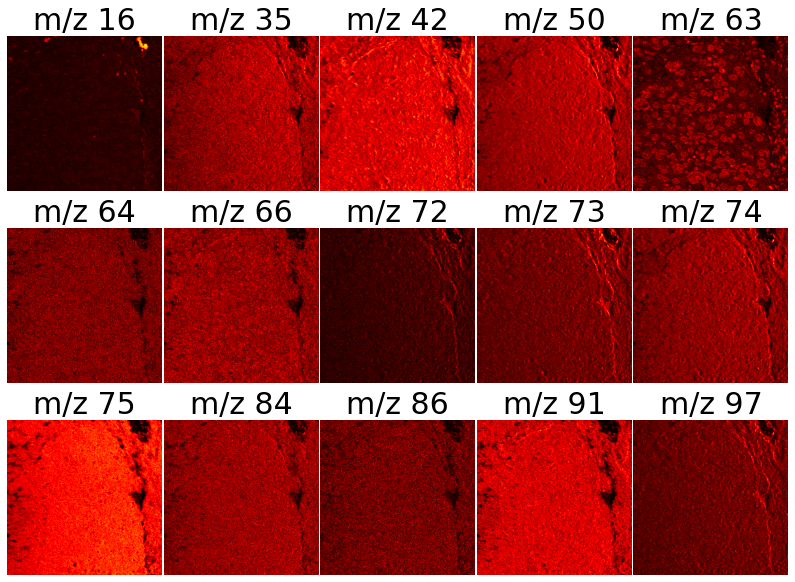

In [70]:
fig, axs = plt.subplots(3,5,figsize=(14,10))
axs=axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(imgs[snr_top_indices[i]+3], cmap='hot')
    ax.set_title(f"m/z {masses[snr_top_indices[i]+3]}", fontsize=30)
    ax.axis('off')
fig.subplots_adjust(wspace=0.01)

# Read lipid and AC list

In [7]:
ac_mass = [44, 70, 73, 56, 84, 42, 82, 86, 61, 74, 72]
ac_index = [SIMS_masses.index(i) for i in ac_mass]
ac_names = ['Alanine', 'Arginine', 'Asparagine', 'Glutamine', 'Glutamine acid', 'Glycine', 'Histidine', 'Leucine/Isoleucine', 'Methionine', 'Threonine', 'Valine']

In [8]:
df_lipid = pd.read_csv(data_dir / 'metadata' / 'lipid.csv')
df_lipid = df_lipid[['Mass', 'Name']]

lipid_mass = df_lipid.Mass.values.tolist()
lipid_names = df_lipid.Name.values.tolist()
lipid_index = [SIMS_masses.index(i) for i in lipid_mass]

In [15]:
imgs, labels, fov= get_imgs(experiment, datasets[8])

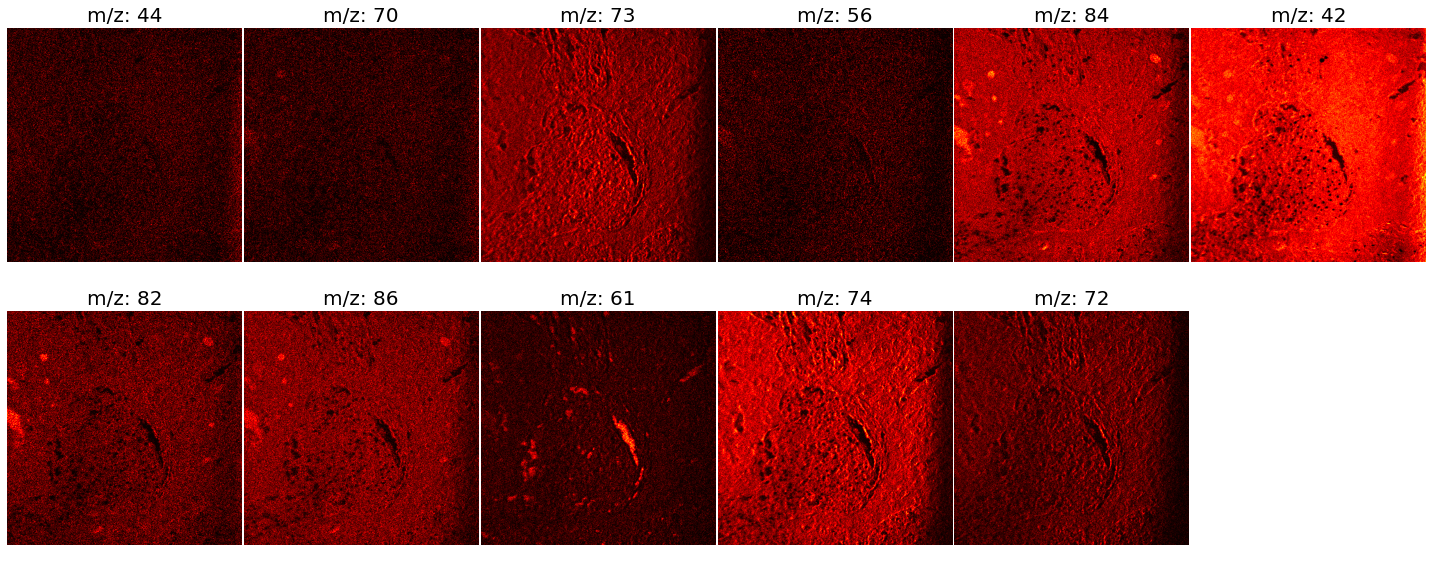

In [16]:
fig, axs = plt.subplots(2,6, figsize=(20,8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    try:
        idx = ac_index[i]
        ax.imshow(imgs[idx], cmap='hot')
        ax.set_title(f'm/z: {ac_mass[i]}', fontsize=20)
    except:pass
    ax.axis('off')
fig.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

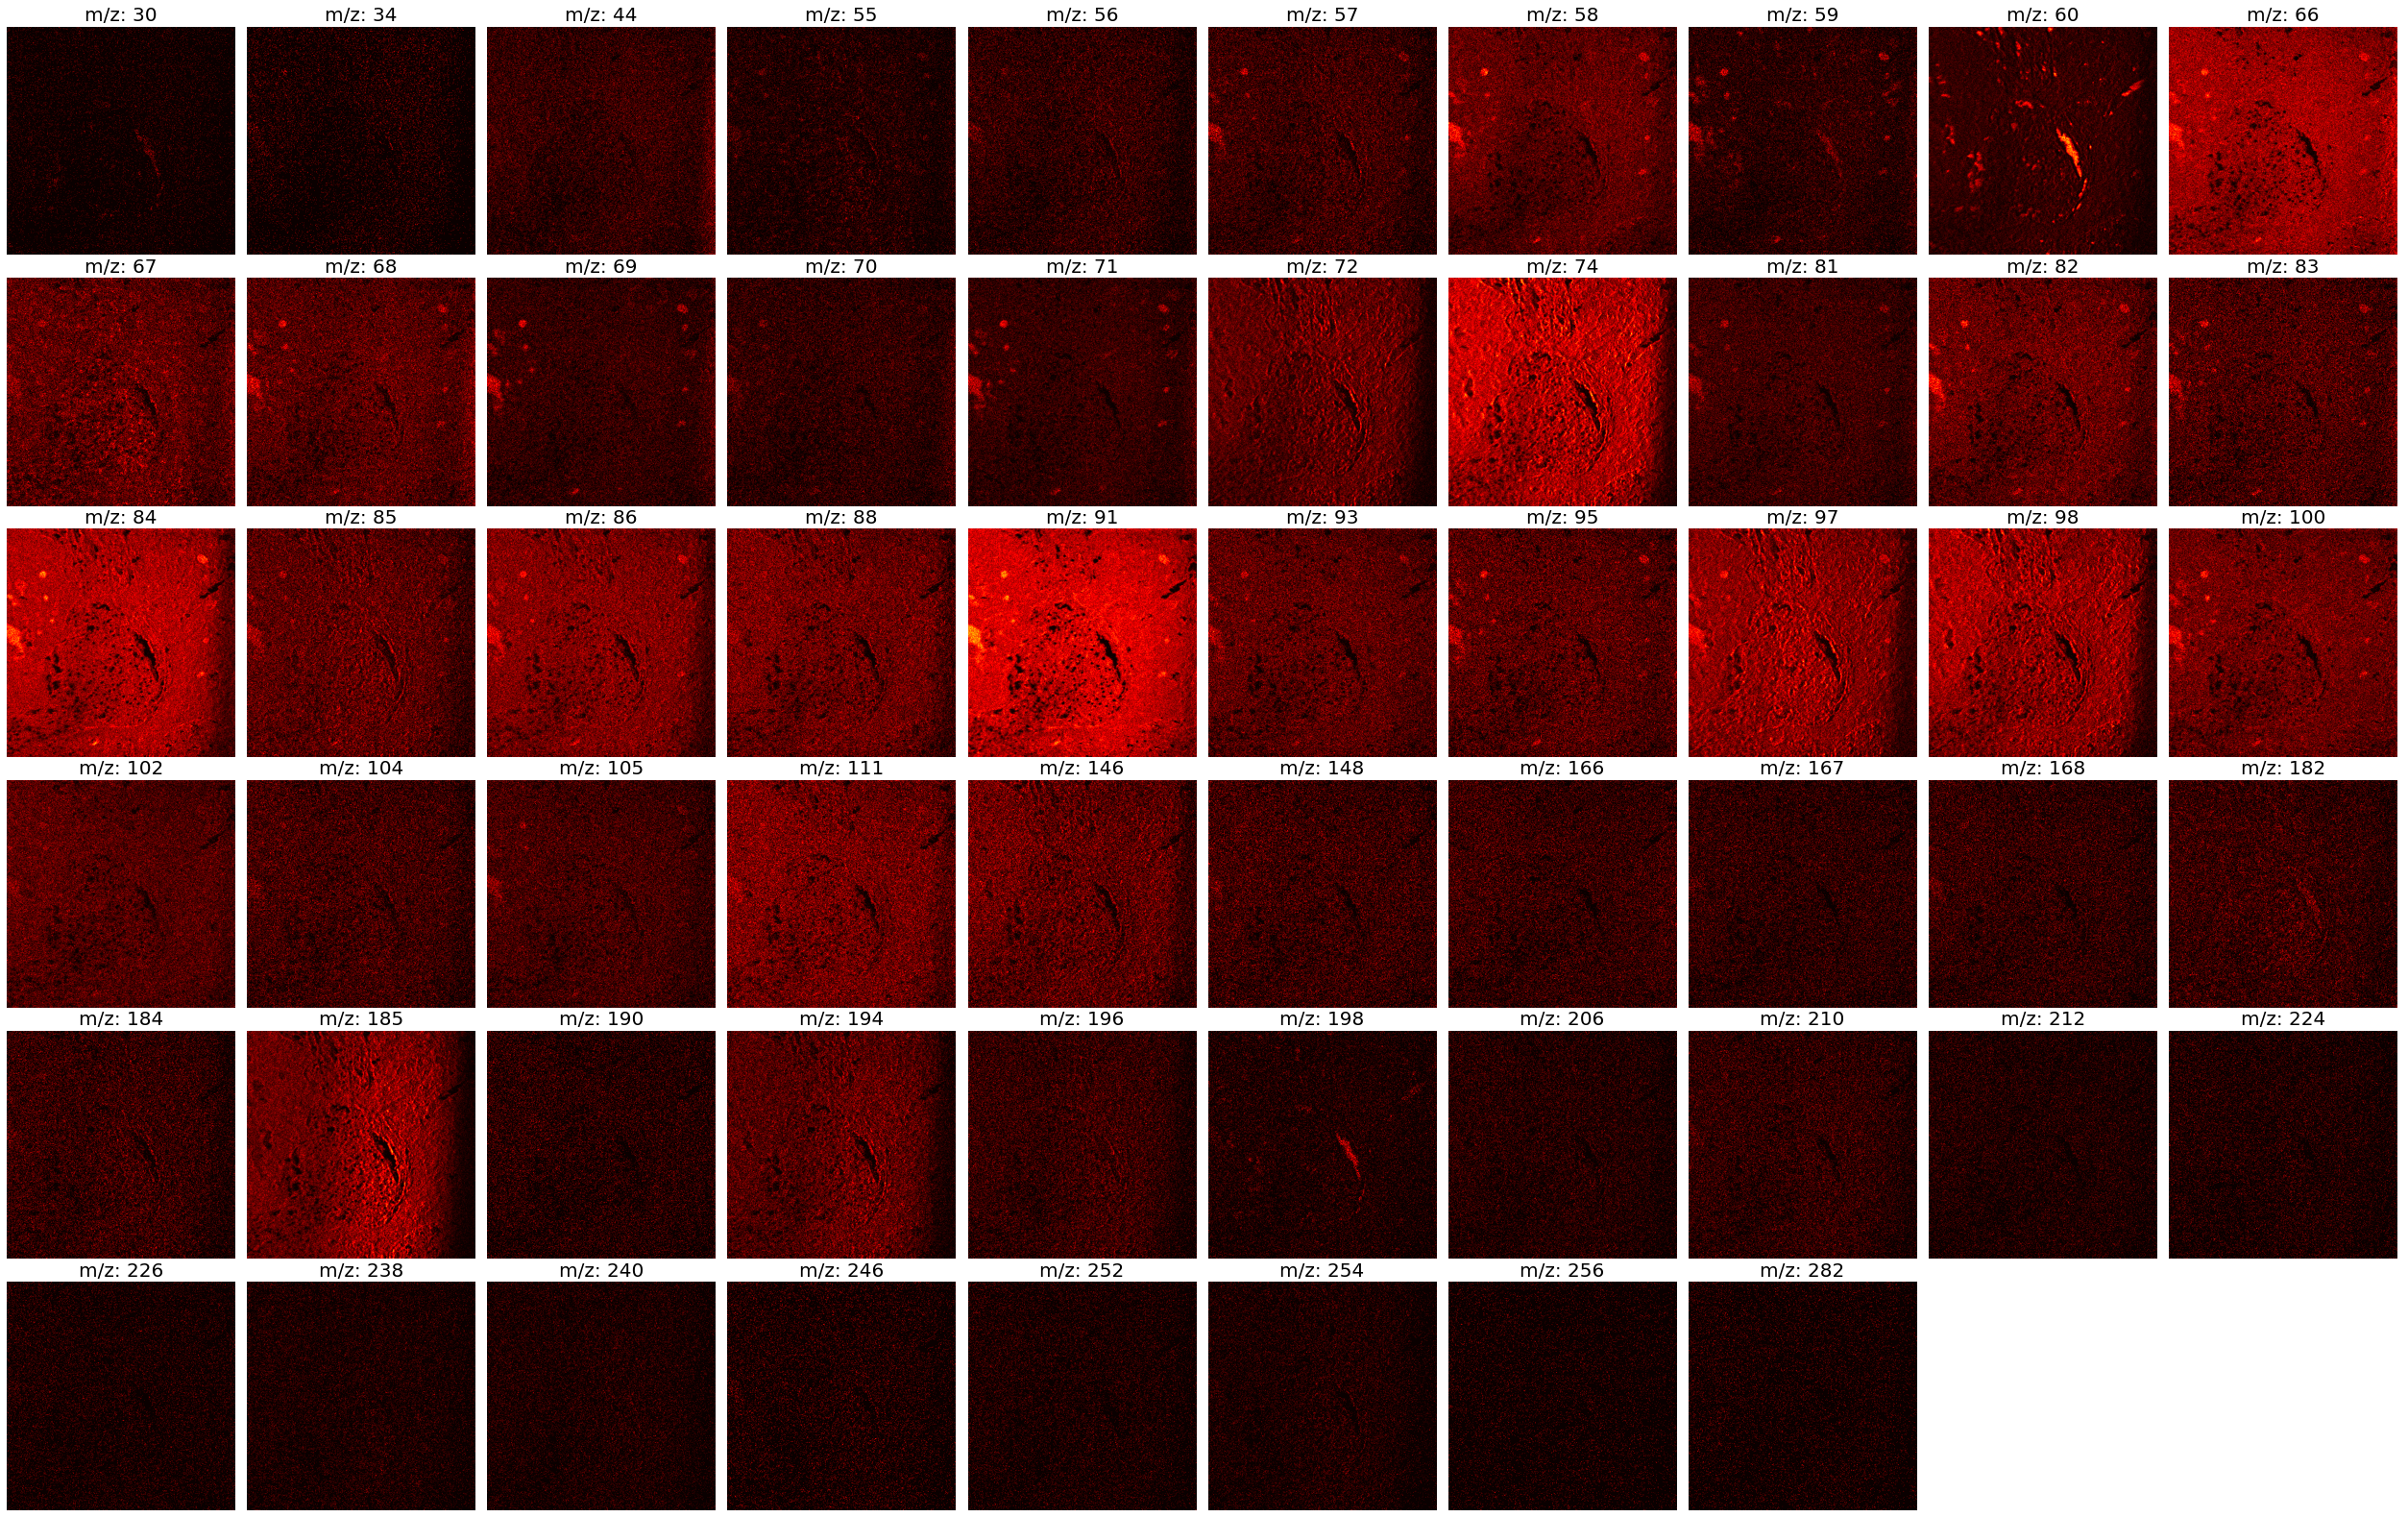

In [17]:
fig, axs = plt.subplots(6,10, figsize=(35,22))
axs = axs.flatten()
for i, ax in enumerate(axs):
    try:
        idx = lipid_index[i]
        ax.imshow(imgs[idx], cmap='hot')
        ax.set_title(f'm/z: {lipid_mass[i]}', fontsize=20)
    except:pass
    ax.axis('off')
fig.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()